In [7]:
import os
import json
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Ellipse
import numpy as np
import pickle
import pandas as pd

In [ ]:
from modules import (
    get_data_from_trajectory_id,
    create_simple_dataloader,
    Step_1,
    Step_2,
    CombinedHamiltonianLayer,
    SimpleStackedHamiltonianNetwork,
    ReverseStep2,
    ReverseStep1,
    ReverseCombinedHamiltonianLayer,
    InverseStackedHamiltonianNetwork,
    prediction_loss,
    load_checkpoint
    )

In [49]:
with open("all_dataframes.pkl", "rb") as f:
    loaded_dfs = pickle.load(f)

# Access them like before:
train_df = loaded_dfs['train_df']
val_df = loaded_dfs['val_df']
test_df = loaded_dfs['test_df']

train_id_df = loaded_dfs['train_id_df']
val_id_df = loaded_dfs['val_id_df']
test_id_df = loaded_dfs['test_id_df']

val_df_high_energy = loaded_dfs['val_df_high_energy']
val_id_df_high_energy = loaded_dfs['val_id_df_high_energy']
test_id_df_high_energy = loaded_dfs['test_id_df_high_energy']

In [ ]:
def calculate_phi_A(x0, u0, k=1, mass=1):
    constant = -(k / mass)
    #For analytical solutions
    A = np.sqrt(np.square(x0)+(np.square(u0)/(-constant)))
    omega = np.sqrt(-constant)
    phi = np.arctan2(x0/A, u0/(omega*A))
    return phi, A

In [12]:
def add_phi_A_columns(df):
    # Apply the function row-wise and expand the result into two columns
    df[['phi', 'A']] = df.apply(
        lambda row: pd.Series(calculate_phi_A(x0=row['x0'], u0=row['u0'], k=1, mass=1)), axis=1
    )

    # Reorder columns: insert phi and A right after 'energy'
    cols = list(df.columns)
    energy_idx = cols.index('energy')
    
    # Remove the new columns from the end
    cols.remove('phi')
    cols.remove('A')
    
    # Insert them right after 'energy'
    cols[energy_idx+1:energy_idx+1] = ['phi', 'A']
    
    # Return reordered dataframe
    return df[cols]




In [46]:
def plot_differencies(df):


    fig, axes = plt.subplots(3, 2, figsize=(12, 12))
    axes = axes.flatten()
    
    # Row 1: X_mean vs A and phi
    axes[0].scatter(df['X_mean'], df['A'], s=20)
    axes[0].set_xlabel('X_mean')
    axes[0].set_ylabel('A')
    axes[0].set_title('A vs X_mean')
    
    axes[1].scatter(df['X_mean'], df['phi'], s=20)
    axes[1].set_xlabel('X_mean')
    axes[1].set_ylabel('phi')
    axes[1].set_title('phi vs X_mean')
    
    # Row 2: U_mean vs A and phi
    axes[2].scatter(df['U_mean'], df['A'], s=20)
    axes[2].set_xlabel('U_mean')
    axes[2].set_ylabel('A')
    axes[2].set_title('A vs U_mean')
    
    axes[3].scatter(df['U_mean'], df['phi'], s=20)
    axes[3].set_xlabel('U_mean')
    axes[3].set_ylabel('phi')
    axes[3].set_title('phi vs U_mean')
    
    # Row 3: A vs phi (leave the other cell empty)
    axes[4].scatter(df['A'], df['phi'], s=20)
    axes[4].set_xlabel('A')
    axes[4].set_ylabel('phi')
    axes[4].set_title('phi vs A')
    
    # Hide the last unused subplot (bottom-right)
    axes[5].axis('off')
    
    plt.tight_layout()
    plt.show()


In [172]:


def plot_prediction_vs_ground_truth(x, u, x_pred, u_pred, pred_loss_full_trajectory, t, trajectory_id,
                                     point_indexes_observed, figsize=(12, 7), connect_points=False):
    """
    Plot ground truth vs predictions with loss metric and time visualization.
    
    Parameters:
    -----------
    x : tensor
        Ground truth x values
    u : tensor
        Ground truth u values
    x_pred : tensor
        Predicted x values
    u_pred : tensor
        Predicted u values
    pred_loss_full_trajectory : tensor
        Loss metric (scalar)
    t : tensor
        Time values for the trajectory
    trajectory_id : int or str
        Trajectory identifier
    point_indexes_observed : list
        List of observed point indexes
    figsize : tuple, optional
        Figure size (width, height)
    connect_points : bool, optional
        Whether to connect points with lines (for trajectories)
    """
    # Convert tensors to numpy
    x_np = x.detach().cpu().numpy().flatten()
    u_np = u.detach().cpu().numpy().flatten()
    x_pred_np = x_pred.detach().cpu().numpy().flatten()
    u_pred_np = u_pred.detach().cpu().numpy().flatten()
    t_np = t.detach().cpu().numpy().flatten()
    loss_value = pred_loss_full_trajectory.item()
    
    # Print observed times (not shown in plot)
    t_observed = t[point_indexes_observed].detach().cpu().numpy()
    print(f"Observed time points: {t_observed}")
    
    # Get number of observed points
    num_observed = len(point_indexes_observed)

    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)

    # Plot with time-based colormaps (using very different color schemes)
    scatter_gt = ax.scatter(x_np, u_np, c=t_np, cmap='Blues', 
                            label='Ground Truth', alpha=0.8, s=60, edgecolors='darkblue', linewidths=0.5)
    scatter_pred = ax.scatter(x_pred_np, u_pred_np, c=t_np, cmap='Reds', 
                              label='Prediction', alpha=0.8, s=60, edgecolors='darkred', linewidths=0.5)

    # Connect points with lines if requested
    if connect_points:
        ax.plot(x_np, u_np, 'b-', alpha=0.3, linewidth=1.5)
        ax.plot(x_pred_np, u_pred_np, 'r-', alpha=0.3, linewidth=1.5)

    # Mark initial points (t=0) with stars only
    ax.scatter(x_np[0], u_np[0], c='blue', marker='*', s=400, 
               edgecolors='black', linewidths=2.5, label='Start (Ground Truth)', zorder=5)
    ax.scatter(x_pred_np[0], u_pred_np[0], c='red', marker='*', s=400, 
               edgecolors='black', linewidths=2.5, label='Start (Prediction)', zorder=5)

    # Add colorbars for time (side by side)
    cbar_gt = plt.colorbar(scatter_gt, ax=ax, pad=0.02, fraction=0.046)
    cbar_gt.set_label('Time (Ground Truth)', fontsize=10, color='darkblue', fontweight='bold')
    cbar_gt.ax.tick_params(labelsize=9)
    
    cbar_pred = plt.colorbar(scatter_pred, ax=ax, pad=0.12, fraction=0.046)
    cbar_pred.set_label('Time (Prediction)', fontsize=10, color='darkred', fontweight='bold')
    cbar_pred.ax.tick_params(labelsize=9)
    
    # Add labels and title
    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('u', fontsize=12)
    ax.set_title(f'Prediction vs Ground Truth - Trajectory ID: {trajectory_id}', fontsize=14, fontweight='bold')
    ax.legend(fontsize=9, loc='best')
    ax.grid(True, alpha=0.3)

    # Add loss metric, time range, and number of observed points as text box
    textstr = f'Loss: {loss_value:.4f}\nTime range: [{t_np[0]:.2f}, {t_np[-1]:.2f}]\nObserved points: {num_observed}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, 
            fontsize=11, verticalalignment='top', bbox=props)

    plt.tight_layout()
    plt.show()




In [15]:
train_id_df_added = add_phi_A_columns(train_id_df)
val_id_df_added = add_phi_A_columns(val_id_df)
val_id_df_high_energy_added = add_phi_A_columns(val_id_df_high_energy)

In [19]:
save_dir_path = "./save_directory_2" 


In [32]:

def analyze_means_with_constants(
    save_dir_path,
    specific_epoch='last',
    train_id_df_added=None,
    val_id_df_added=None,
    val_id_df_high_energy_added=None
):
    """
    Extracts X_mean and U_mean for all trajectories at a specific epoch from
    each of the 3 directories, and combines them with (A, phi) constants
    from the provided DataFrames.

    Args:
        save_dir_path (str): Path to the directory containing epoch_* folders.
        specific_epoch (int or str): Epoch number (e.g., 5) or 'last' for the last epoch.
        train_id_df_added (pd.DataFrame): DataFrame with columns ['trajectory_id', 'A', 'phi'] for train set.
        val_id_df_added (pd.DataFrame): DataFrame with columns ['trajectory_id', 'A', 'phi'] for validation set.
        val_id_df_high_energy_added (pd.DataFrame): DataFrame with columns ['trajectory_id', 'A', 'phi'] for high energy validation set.

    Returns:
        tuple: (val_df, val_train_set_df, val_high_energy_df)
               Each is a DataFrame with columns ['trajectory_id', 'X_mean', 'U_mean', 'A', 'phi'].
    """

    # --- Helper function to load data for a specific subdirectory ---
    def extract_means_for_dir(epoch_path, subdir_name, constants_df):
        subdir_path = os.path.join(epoch_path, subdir_name)
        if not os.path.exists(subdir_path):
            print(f"⚠️ Warning: {subdir_path} not found.")
            return pd.DataFrame(columns=['trajectory_id', 'X_mean', 'U_mean', 'A', 'phi'])

        data = []
        for file in os.listdir(subdir_path):
            if not file.startswith("trajectory_id_") or not file.endswith(".json"):
                continue
            try:
                traj_id = int(file.split("_")[2])
                file_path = os.path.join(subdir_path, file)
                with open(file_path, "r") as f:
                    json_data = json.load(f)
                X_mean = json_data.get("X_mean", None)
                U_mean = json_data.get("U_mean", None)

                if constants_df is not None and traj_id in constants_df["trajectory_id"].values:
                    row = constants_df[constants_df["trajectory_id"] == traj_id].iloc[0]
                    A, phi = row["A"], row["phi"]
                else:
                    A, phi = None, None

                data.append({
                    "trajectory_id": traj_id,
                    "X_mean": X_mean,
                    "U_mean": U_mean,
                    "A": A,
                    "phi": phi
                })
            except Exception as e:
                print(f"⚠️ Error reading {file}: {e}")

        return pd.DataFrame(data)

    # --- Determine which epoch directory to use ---
    epoch_dirs = sorted(
        [d for d in os.listdir(save_dir_path) if d.startswith("epoch_")],
        key=lambda x: int(x.split("_")[1])
    )

    if not epoch_dirs:
        raise FileNotFoundError(f"No epoch directories found in {save_dir_path}")

    if specific_epoch == 'last':
        epoch_dir_name = epoch_dirs[-1]
    else:
        epoch_dir_name = f"epoch_{specific_epoch}"
        if epoch_dir_name not in epoch_dirs:
            raise ValueError(f"Epoch {specific_epoch} not found in {save_dir_path}")

    epoch_path = os.path.join(save_dir_path, epoch_dir_name)
    print(f"📂 Using data from epoch: {epoch_dir_name}")

    # --- Extract for each of the 3 trajectory sets ---
    val_df = extract_means_for_dir(epoch_path, "val_trajectories_data", val_id_df_added)
    val_train_set_df = extract_means_for_dir(epoch_path, "val_train_set_trajectories_data", train_id_df_added)
    val_high_energy_df = extract_means_for_dir(epoch_path, "val_high_energy_trajectories_data", val_id_df_high_energy_added)

    print("✅ Data extraction complete.")
    return val_df, val_train_set_df, val_high_energy_df


In [26]:


def visualize_trajectory_movements_with_std_ellipses(
    save_dir_path,
    number_of_points_to_plot=5,
    right_plot_alpha=0.3,
    verbose=False,
    specific_epoch='last',
    visualize_true_constants=False,
    train_id_df_added=None,
    val_id_df_added=None,
    val_id_df_high_energy_added=None
):
    """
    Visualizes how X_mean/U_mean evolve (left plot) and how X_std/U_std change (right plot)
    using ellipses at the same coordinates to represent standard deviation magnitudes.
    
    Args:
        save_dir_path: Path to the directory containing epoch folders
        number_of_points_to_plot: Number of trajectory IDs to randomly select
        right_plot_alpha: Transparency level for ellipses in right plots (0.0 to 1.0)
        verbose: If True, print trajectory values for a specific epoch
        specific_epoch: Either an integer epoch number or 'last' for the last epoch
        visualize_true_constants: If True, plot (A, phi) of selected trajectories on left plots
        *_id_df_added: DataFrames containing true constants for each dataset
    """

    traj_dirs = [
        "val_trajectories_data",
        "val_train_set_trajectories_data",
        "val_high_energy_trajectories_data"
    ]

    # Ensure correct mapping between directory and DataFrame
    df_map = {
        "val_trajectories_data": val_id_df_added,
        "val_train_set_trajectories_data": train_id_df_added,
        "val_high_energy_trajectories_data": val_id_df_high_energy_added
    }

    epoch_dirs = sorted(
        [d for d in os.listdir(save_dir_path) if d.startswith("epoch_")],
        key=lambda x: int(x.split("_")[1])
    )
    num_epochs = len(epoch_dirs)
    if num_epochs == 0:
        print("❌ No epoch directories found.")
        return

    # Color palettes
    epoch_cmap = cm.get_cmap("viridis")
    epoch_colors = [epoch_cmap(i / (num_epochs - 1)) for i in range(num_epochs)]
    traj_id_cmap = cm.get_cmap("tab10")

    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
    fig.subplots_adjust(hspace=0.4, wspace=0.3)

    for row_idx, traj_dir in enumerate(traj_dirs):
        print(f"\n📊 Processing directory: {traj_dir}")

        df = df_map.get(traj_dir, None)
        first_epoch_path = os.path.join(save_dir_path, epoch_dirs[0], traj_dir)
        if not os.path.exists(first_epoch_path):
            print(f"⚠️ Directory {first_epoch_path} not found. Skipping.")
            continue

        all_files = [f for f in os.listdir(first_epoch_path) if f.startswith("trajectory_id_") and f.endswith(".json")]
        if not all_files:
            print(f"⚠️ No trajectory files found in {first_epoch_path}.")
            continue

        trajectory_ids = [int(f.split("_")[2]) for f in all_files]
        random.seed(42)
        selected_ids = random.sample(trajectory_ids, min(number_of_points_to_plot, len(trajectory_ids)))

        # Consistent unique colors per trajectory ID
        traj_colors = {tid: traj_id_cmap(i / max(len(selected_ids) - 1, 1)) for i, tid in enumerate(selected_ids)}

        traj_data = {
            tid: {"X_mean": [], "U_mean": [], "X_std": [], "U_std": []}
            for tid in selected_ids
        }

        for epoch_dir in epoch_dirs:
            epoch_path = os.path.join(save_dir_path, epoch_dir, traj_dir)
            for tid in selected_ids:
                file_path = os.path.join(epoch_path, f"trajectory_id_{tid}_data.json")
                if not os.path.exists(file_path):
                    continue
                with open(file_path, "r") as f:
                    data = json.load(f)
                traj_data[tid]["X_mean"].append(data["X_mean"])
                traj_data[tid]["U_mean"].append(data["U_mean"])
                traj_data[tid]["X_std"].append(data["X_std"])
                traj_data[tid]["U_std"].append(data["U_std"])

        # --- Left plot: Means ---
        ax_mean = axes[row_idx, 0]
        ax_mean.set_title(f"{traj_dir.replace('_', ' ')} - Mean Evolution")
        ax_mean.set_xlabel("X_mean")
        ax_mean.set_ylabel("U_mean")
        ax_mean.grid(True, linestyle="--", alpha=0.5)

        for tid in selected_ids:
            Xs = traj_data[tid]["X_mean"]
            Us = traj_data[tid]["U_mean"]
            color = traj_colors[tid]
            if len(Xs) < 2:
                continue
            for j in range(len(Xs) - 1):
                ax_mean.plot([Xs[j], Xs[j+1]], [Us[j], Us[j+1]], color=epoch_colors[j], alpha=0.8, linewidth=2)
            ax_mean.scatter(Xs[0], Us[0], color="red", marker="o", s=40)
            ax_mean.scatter(Xs[-1], Us[-1], color="black", marker="x", s=40)

        # Highlight specific epoch with colored star
        epoch_idx = None
        if specific_epoch is not None:
            if specific_epoch == 'last':
                epoch_idx = len(epoch_dirs) - 1
            else:
                epoch_name = f"epoch_{specific_epoch}"
                if epoch_name in epoch_dirs:
                    epoch_idx = epoch_dirs.index(epoch_name)

        if epoch_idx is not None:
            for tid in selected_ids:
                Xs = traj_data[tid]["X_mean"]
                Us = traj_data[tid]["U_mean"]
                if epoch_idx < len(Xs):
                    ax_mean.scatter(
                        Xs[epoch_idx],
                        Us[epoch_idx],
                        color=traj_colors[tid],
                        marker='*',
                        s=300,
                        edgecolor='black',
                        linewidth=1.5,
                        zorder=10
                    )

        # --- Optional True Constants Visualization ---
        if visualize_true_constants and df is not None:
            const_points = df[df["trajectory_id"].isin(selected_ids)]
            for _, row in const_points.iterrows():
                tid = row["trajectory_id"]
                color = traj_colors.get(tid, "orange")
                ax_mean.scatter(
                    row["A"], row["phi"],
                    color=color, s=120, marker="D",
                    edgecolor="black", linewidth=1.5, zorder=15
                )
        ax_mean.legend(["Trajectory evolution", "Start", "End", "Specific epoch / True (A, φ)"], fontsize=8)

        # --- Right plot: Std Ellipses ---
        ax_std = axes[row_idx, 1]
        ax_std.set_title(f"{traj_dir.replace('_', ' ')} - Std Ellipses")
        ax_std.set_xlabel("X_mean")
        ax_std.set_ylabel("U_mean")
        ax_std.grid(True, linestyle="--", alpha=0.5)

        for tid in selected_ids:
            Xs = traj_data[tid]["X_mean"]
            Us = traj_data[tid]["U_mean"]
            Xstds = traj_data[tid]["X_std"]
            Ustds = traj_data[tid]["U_std"]
            color = traj_colors[tid]
            for j in range(len(Xs)):
                e = Ellipse(
                    (Xs[j], Us[j]),
                    width=Xstds[j] * 2,
                    height=Ustds[j] * 2,
                    facecolor=color,
                    edgecolor="black",
                    alpha=right_plot_alpha
                )
                ax_std.add_patch(e)
            ax_std.plot(Xs, Us, color=color, alpha=right_plot_alpha, linewidth=1, label=f"Traj {tid}")

        # Highlight specific epoch in right plot
        if epoch_idx is not None:
            for tid in selected_ids:
                Xs = traj_data[tid]["X_mean"]
                Us = traj_data[tid]["U_mean"]
                if epoch_idx < len(Xs):
                    ax_std.scatter(
                        Xs[epoch_idx], Us[epoch_idx],
                        color=traj_colors[tid],
                        marker='*', s=300,
                        edgecolor='black', linewidth=1.5, zorder=10
                    )

        ax_std.legend(loc="best", fontsize=8, framealpha=0.7)

        # Colorbar for epoch progression (left plot)
        norm = plt.Normalize(vmin=0, vmax=num_epochs - 1)
        sm = plt.cm.ScalarMappable(cmap=epoch_cmap, norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=axes[row_idx, 0], orientation="horizontal", fraction=0.05, pad=0.1)
        cbar.set_label("Epoch progression")

        # --- Verbose output ---
        if verbose and epoch_idx is not None:
            epoch_name = epoch_dirs[epoch_idx]
            print(f"\nFor the {epoch_name} in {traj_dir} the values are:")
            for tid in selected_ids:
                if epoch_idx < len(traj_data[tid]["X_mean"]):
                    X_mean = traj_data[tid]["X_mean"][epoch_idx]
                    X_std = traj_data[tid]["X_std"][epoch_idx]
                    U_mean = traj_data[tid]["U_mean"][epoch_idx]
                    U_std = traj_data[tid]["U_std"][epoch_idx]

                    # Get A, phi from dataframe if available
                    A, phi = None, None
                    if df is not None and tid in df["trajectory_id"].values:
                        row = df[df["trajectory_id"] == tid].iloc[0]
                        A, phi = row["A"], row["phi"]

                    print(f"{tid}: X_mean = {X_mean:.4f} ± {X_std:.4f}, "
                          f"U_mean = {U_mean:.4f} ± {U_std:.4f} "
                          f"and A={A}, phi={phi}")
                else:
                    print(f"{tid}: No data available")

    plt.tight_layout()
    plt.show()
    print("\n✅ Mean + Std (ellipse) visualization complete.")


In [27]:

def visualize_epoch_metrics(save_dir_path, metrics_to_plot, plot_on_same_graph=False, verbose=False):
    """
    Visualizes selected metrics from epoch directories.

    Args:
        save_dir_path (str): Path to the main directory containing 'epoch_n' subdirectories.
        metrics_to_plot (list of str): List of metric names to visualize.
        plot_on_same_graph (bool): If True, group related metrics (train/val variants) on the same plot.
        verbose (bool): If True, prints summary statistics for each metric.
    """

    # --- Collect all epoch directories ---
    epoch_dirs = sorted(
        [d for d in os.listdir(save_dir_path) if d.startswith("epoch_")],
        key=lambda x: int(x.split("_")[1])
    )

    # --- Collect data ---
    metrics_data = {metric: [] for metric in metrics_to_plot}
    epochs = []

    for d in epoch_dirs:
        epoch_path = os.path.join(save_dir_path, d, "epoch_metrics.json")
        if not os.path.isfile(epoch_path):
            print(f"⚠️ Skipping {d} (no epoch_metrics.json found)")
            continue

        with open(epoch_path, "r") as f:
            data = json.load(f)

        epoch_num = data.get("epoch", int(d.split("_")[1]))
        epochs.append(epoch_num)

        for metric in metrics_to_plot:
            metrics_data[metric].append(data.get(metric, None))

    # --- Verbose logging of statistics ---
    if verbose:
        print("\n📊 Metric summaries:")
        for metric in metrics_to_plot:
            values = [v for v in metrics_data[metric] if v is not None]
            if not values:
                print(f"  ⚠️ Metric {metric} has no valid values.")
                continue

            min_val = min(values)
            min_epoch = epochs[metrics_data[metric].index(min_val)]
            last_5 = values[-5:] if len(values) >= 5 else values
            print(
                f"  Lowest loss of metric '{metric}' recorded in epoch {min_epoch} "
                f"with the value: {min_val:.6f}, "
                f"the losses of the last 5 epochs are: {last_5}"
            )

    # --- Color scheme for each data source ---
    data_colors = {
        "train": "tab:blue",
        "val": "tab:orange",
        "val_high_energy": "tab:green",
        "val_training_set": "tab:red",
        "other": "tab:gray"
    }

    # --- Helper: identify data prefix and core metric ---
    def split_metric_name(metric):
        """
        Returns (data_prefix, core_metric)
        Handles trailing underscores and variants like _high_energy / _training_set.
        """
        m = metric.rstrip("_")  # remove trailing underscores

        prefix = "other"
        core = m

        if m.startswith("train_"):
            prefix = "train"
            core = m[len("train_"):]
        elif m.startswith("val_"):
            core = m[len("val_"):]
            if "_high_energy" in core:
                prefix = "val_high_energy"
                core = core.replace("_high_energy", "")
            elif "_training_set" in core:
                prefix = "val_training_set"
                core = core.replace("_training_set", "")
            else:
                prefix = "val"

        core = core.rstrip("_")
        return prefix, core

    # --- Plotting ---
    if plot_on_same_graph:
        # Group metrics by core metric name
        grouped = {}
        for metric in metrics_to_plot:
            prefix, core = split_metric_name(metric)
            grouped.setdefault(core, {})[prefix] = metric

        for core_metric, variants in grouped.items():
            plt.figure(figsize=(8, 5))
            for prefix, metric in variants.items():
                plt.plot(
                    epochs,
                    metrics_data[metric],
                    marker='o',
                    label=metric,
                    color=data_colors.get(prefix, None)
                )

            plt.title(f"{core_metric.replace('_', ' ').title()} across datasets")
            plt.xlabel("Epoch")
            plt.ylabel(core_metric)
            plt.grid(True, linestyle="--", alpha=0.6)
            plt.legend()
            plt.tight_layout()
            plt.show()
    else:
        for metric in metrics_to_plot:
            prefix, _ = split_metric_name(metric)
            plt.figure(figsize=(8, 5))
            plt.plot(
                epochs,
                metrics_data[metric],
                marker='o',
                label=metric,
                color=data_colors.get(prefix, None)
            )
            plt.title(f"{metric.replace('_', ' ').title()} over epochs")
            plt.xlabel("Epoch")
            plt.ylabel(metric)
            plt.grid(True, linestyle="--", alpha=0.6)
            plt.legend()
            plt.tight_layout()
            plt.show()

    print("\n✅ Visualization complete.")



In [28]:
def analyze_folders_means(save_dir_path, locate_epoch=None):
    """
    Analyzes the mean and standard deviation of X_mean and U_mean across all trajectory IDs
    for each epoch and trajectory directory.
    
    Creates 3 plots showing how X_std_full and U_std_full evolve over epochs.
    
    Args:
        save_dir_path: Path to the directory containing epoch folders
        locate_epoch: If provided (integer), highlights this epoch in plots and prints its statistics
    """
    
    traj_dirs = [
        "val_trajectories_data",
        "val_train_set_trajectories_data",
        "val_high_energy_trajectories_data"
    ]
    
    epoch_dirs = sorted(
        [d for d in os.listdir(save_dir_path) if d.startswith("epoch_")],
        key=lambda x: int(x.split("_")[1])
    )
    num_epochs = len(epoch_dirs)
    if num_epochs == 0:
        print("❌ No epoch directories found.")
        return
    
    print(f"📊 Analyzing {num_epochs} epochs across {len(traj_dirs)} directories...")
    
    # Color map for epoch progression
    cmap = cm.get_cmap("plasma")
    colors = [cmap(i / (num_epochs - 1)) for i in range(num_epochs)]
    
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 15))
    fig.suptitle("Evolution of Statistics Across Epochs", fontsize=16, fontweight='bold')
    fig.subplots_adjust(hspace=0.35, wspace=0.3)
    
    # Store data for all directories (for locate_epoch functionality)
    all_data = {}
    
    for row_idx, traj_dir in enumerate(traj_dirs):
        print(f"\n📁 Processing directory: {traj_dir}")
        
        # Storage for aggregated statistics per epoch
        X_mean_full_per_epoch = []
        X_std_full_per_epoch = []
        U_mean_full_per_epoch = []
        U_std_full_per_epoch = []
        
        for epoch_idx, epoch_dir in enumerate(epoch_dirs):
            epoch_path = os.path.join(save_dir_path, epoch_dir, traj_dir)
            
            if not os.path.exists(epoch_path):
                print(f"⚠️ Directory {epoch_path} not found. Skipping epoch.")
                X_mean_full_per_epoch.append(np.nan)
                X_std_full_per_epoch.append(np.nan)
                U_mean_full_per_epoch.append(np.nan)
                U_std_full_per_epoch.append(np.nan)
                continue
            
            # Get all trajectory files in this epoch
            all_files = [f for f in os.listdir(epoch_path) if f.startswith("trajectory_id_") and f.endswith(".json")]
            
            if not all_files:
                print(f"⚠️ No trajectory files found in {epoch_path}.")
                X_mean_full_per_epoch.append(np.nan)
                X_std_full_per_epoch.append(np.nan)
                U_mean_full_per_epoch.append(np.nan)
                U_std_full_per_epoch.append(np.nan)
                continue
            
            # Collect X_mean and U_mean from all trajectories
            X_means = []
            U_means = []
            
            for file_name in all_files:
                file_path = os.path.join(epoch_path, file_name)
                with open(file_path, "r") as f:
                    data = json.load(f)
                    X_means.append(data["X_mean"])
                    U_means.append(data["U_mean"])
            
            # Calculate means and standard deviations across all trajectory IDs
            X_mean_full = np.mean(X_means)
            X_std_full = np.std(X_means)
            U_mean_full = np.mean(U_means)
            U_std_full = np.std(U_means)
            
            X_mean_full_per_epoch.append(X_mean_full)
            X_std_full_per_epoch.append(X_std_full)
            U_mean_full_per_epoch.append(U_mean_full)
            U_std_full_per_epoch.append(U_std_full)
        
        # Store data for this directory
        all_data[traj_dir] = {
            'X_mean_full': X_mean_full_per_epoch,
            'X_std_full': X_std_full_per_epoch,
            'U_mean_full': U_mean_full_per_epoch,
            'U_std_full': U_std_full_per_epoch
        }
        
        # ===== LEFT PLOT: Standard Deviations =====
        ax_std = axes[row_idx, 0]
        ax_std.set_title(f"{traj_dir.replace('_', ' ')} - Std Deviation")
        ax_std.set_xlabel("X_std_full (Std of X_means)")
        ax_std.set_ylabel("U_std_full (Std of U_means)")
        ax_std.grid(True, linestyle="--", alpha=0.5)
        
        # Plot lines connecting epochs
        for i in range(len(X_std_full_per_epoch) - 1):
            if not (np.isnan(X_std_full_per_epoch[i]) or np.isnan(X_std_full_per_epoch[i+1])):
                ax_std.plot(
                    [X_std_full_per_epoch[i], X_std_full_per_epoch[i+1]],
                    [U_std_full_per_epoch[i], U_std_full_per_epoch[i+1]],
                    color=colors[i],
                    alpha=0.8,
                    linewidth=2
                )
        
        # Plot points for each epoch
        valid_indices = [i for i in range(len(X_std_full_per_epoch)) if not np.isnan(X_std_full_per_epoch[i])]
        for i in valid_indices:
            ax_std.scatter(
                X_std_full_per_epoch[i],
                U_std_full_per_epoch[i],
                color=colors[i],
                s=100,
                edgecolor='black',
                linewidth=1.5,
                zorder=5
            )
        
        # Mark start and end
        if valid_indices:
            ax_std.scatter(
                X_std_full_per_epoch[valid_indices[0]],
                U_std_full_per_epoch[valid_indices[0]],
                color='red',
                marker='o',
                s=150,
                edgecolor='black',
                linewidth=2,
                zorder=6,
                label='Start'
            )
            ax_std.scatter(
                X_std_full_per_epoch[valid_indices[-1]],
                U_std_full_per_epoch[valid_indices[-1]],
                color='black',
                marker='x',
                s=150,
                linewidth=3,
                zorder=6,
                label='End'
            )
        
        # Highlight the specific epoch if requested
        if locate_epoch is not None and locate_epoch < len(X_std_full_per_epoch):
            if not np.isnan(X_std_full_per_epoch[locate_epoch]):
                ax_std.scatter(
                    X_std_full_per_epoch[locate_epoch],
                    U_std_full_per_epoch[locate_epoch],
                    color='lime',
                    marker='*',
                    s=400,
                    edgecolor='darkgreen',
                    linewidth=3,
                    zorder=7,
                    label=f'Epoch {locate_epoch}'
                )
        
        if valid_indices or locate_epoch is not None:
            ax_std.legend(loc='best')
        
        # Add colorbar for epoch progression
        norm = plt.Normalize(vmin=0, vmax=num_epochs - 1)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar_std = fig.colorbar(sm, ax=ax_std, orientation="horizontal", fraction=0.05, pad=0.15)
        cbar_std.set_label("Epoch progression")
        
        # ===== RIGHT PLOT: Means =====
        ax_mean = axes[row_idx, 1]
        ax_mean.set_title(f"{traj_dir.replace('_', ' ')} - Mean Values")
        ax_mean.set_xlabel("X_mean_full (Mean of X_means)")
        ax_mean.set_ylabel("U_mean_full (Mean of U_means)")
        ax_mean.grid(True, linestyle="--", alpha=0.5)
        
        # Plot lines connecting epochs
        for i in range(len(X_mean_full_per_epoch) - 1):
            if not (np.isnan(X_mean_full_per_epoch[i]) or np.isnan(X_mean_full_per_epoch[i+1])):
                ax_mean.plot(
                    [X_mean_full_per_epoch[i], X_mean_full_per_epoch[i+1]],
                    [U_mean_full_per_epoch[i], U_mean_full_per_epoch[i+1]],
                    color=colors[i],
                    alpha=0.8,
                    linewidth=2
                )
        
        # Plot points for each epoch
        valid_indices_mean = [i for i in range(len(X_mean_full_per_epoch)) if not np.isnan(X_mean_full_per_epoch[i])]
        for i in valid_indices_mean:
            ax_mean.scatter(
                X_mean_full_per_epoch[i],
                U_mean_full_per_epoch[i],
                color=colors[i],
                s=100,
                edgecolor='black',
                linewidth=1.5,
                zorder=5
            )
        
        # Mark start and end
        if valid_indices_mean:
            ax_mean.scatter(
                X_mean_full_per_epoch[valid_indices_mean[0]],
                U_mean_full_per_epoch[valid_indices_mean[0]],
                color='red',
                marker='o',
                s=150,
                edgecolor='black',
                linewidth=2,
                zorder=6,
                label='Start'
            )
            ax_mean.scatter(
                X_mean_full_per_epoch[valid_indices_mean[-1]],
                U_mean_full_per_epoch[valid_indices_mean[-1]],
                color='black',
                marker='x',
                s=150,
                linewidth=3,
                zorder=6,
                label='End'
            )
        
        # Highlight the specific epoch if requested
        if locate_epoch is not None and locate_epoch < len(X_mean_full_per_epoch):
            if not np.isnan(X_mean_full_per_epoch[locate_epoch]):
                ax_mean.scatter(
                    X_mean_full_per_epoch[locate_epoch],
                    U_mean_full_per_epoch[locate_epoch],
                    color='lime',
                    marker='*',
                    s=400,
                    edgecolor='darkgreen',
                    linewidth=3,
                    zorder=7,
                    label=f'Epoch {locate_epoch}'
                )
        
        if valid_indices_mean or locate_epoch is not None:
            ax_mean.legend(loc='best')
        
        # Add colorbar for epoch progression
        cbar_mean = fig.colorbar(sm, ax=ax_mean, orientation="horizontal", fraction=0.05, pad=0.15)
        cbar_mean.set_label("Epoch progression")
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics for the located epoch
    if locate_epoch is not None:
        print(f"\n{'='*60}")
        print(f"Statistics for Epoch {locate_epoch}:")
        print(f"{'='*60}")
        for traj_dir in traj_dirs:
            if locate_epoch < len(all_data[traj_dir]['X_mean_full']):
                X_mean_full = all_data[traj_dir]['X_mean_full'][locate_epoch]
                X_std_full = all_data[traj_dir]['X_std_full'][locate_epoch]
                U_mean_full = all_data[traj_dir]['U_mean_full'][locate_epoch]
                U_std_full = all_data[traj_dir]['U_std_full'][locate_epoch]
                
                if not np.isnan(X_mean_full):
                    print(f"\n{traj_dir}:")
                    print(f"  X: {X_mean_full:.6f} ± {X_std_full:.6f}")
                    print(f"  U: {U_mean_full:.6f} ± {U_std_full:.6f}")
                else:
                    print(f"\n{traj_dir}: No data available")
            else:
                print(f"\n{traj_dir}: Epoch {locate_epoch} not found")
        print(f"{'='*60}")
    


📊 Metric summaries:
  Lowest loss of metric 'train_prediction_loss_' recorded in epoch 498 with the value: 12.543022, the losses of the last 5 epochs are: [13.301555801521648, 13.831858548251065, 12.543021597645499, 13.374735913493417, 13.136265494606711]
  Lowest loss of metric 'val_prediction_loss_' recorded in epoch 402 with the value: 8.358166, the losses of the last 5 epochs are: [9.05674378077189, 9.17406932512919, 9.029113491376242, 9.181456724802652, 9.192890842755636]
  Lowest loss of metric 'val_prediction_loss_training_set' recorded in epoch 470 with the value: 11.297474, the losses of the last 5 epochs are: [11.649192641178766, 11.590355813503265, 11.636041114727655, 11.569947451353073, 11.561371425787607]
  Lowest loss of metric 'train_variance_loss_' recorded in epoch 465 with the value: 17.673012, the losses of the last 5 epochs are: [17.70864301378077, 17.804602205753326, 17.80335716225884, 17.829662799835205, 17.84967267513275]
  Lowest loss of metric 'val_variance_lo

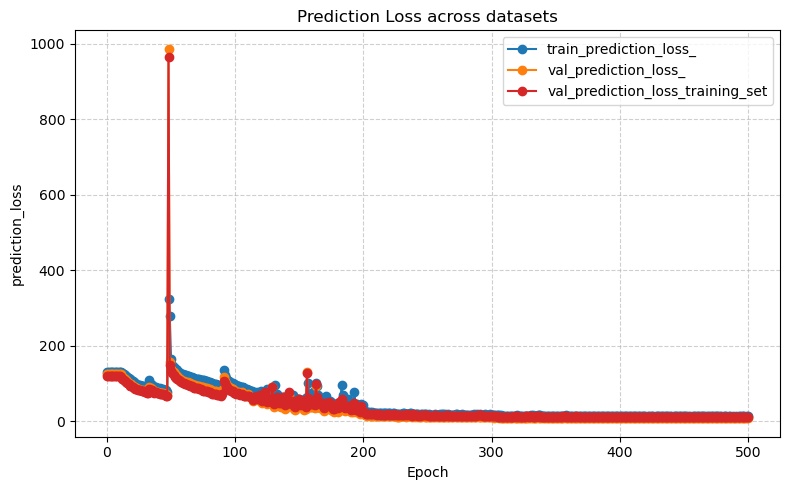

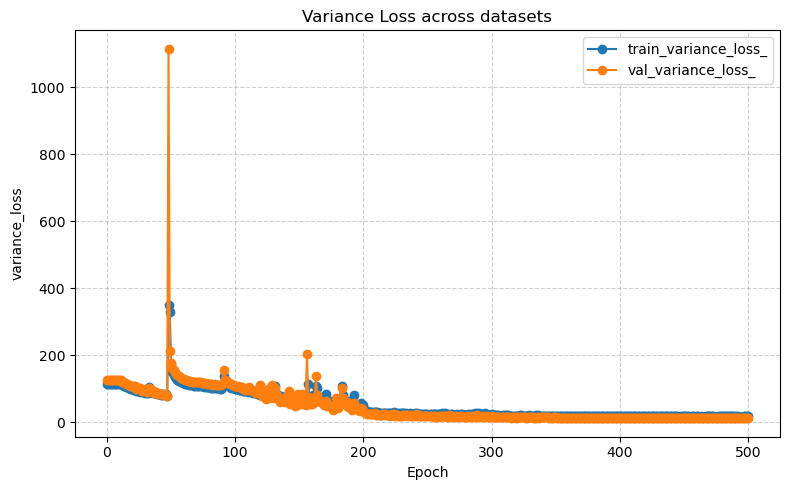

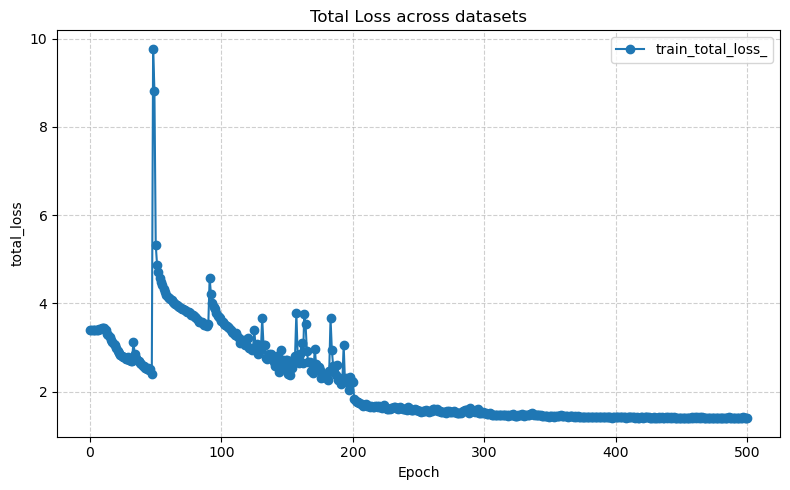

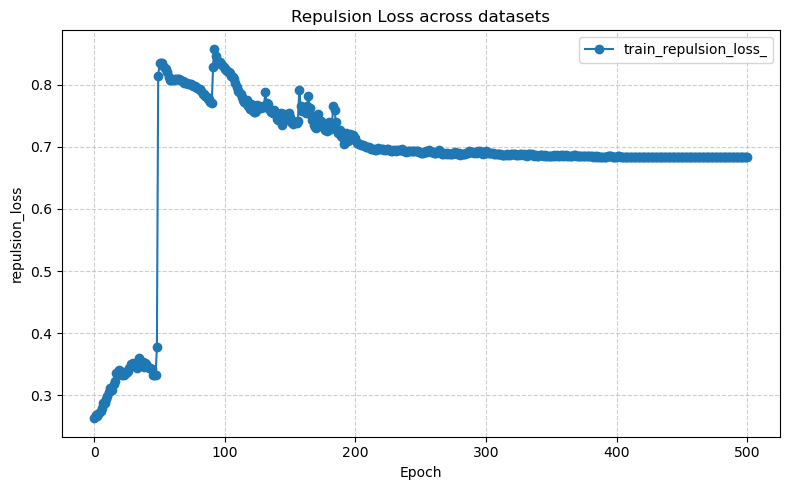

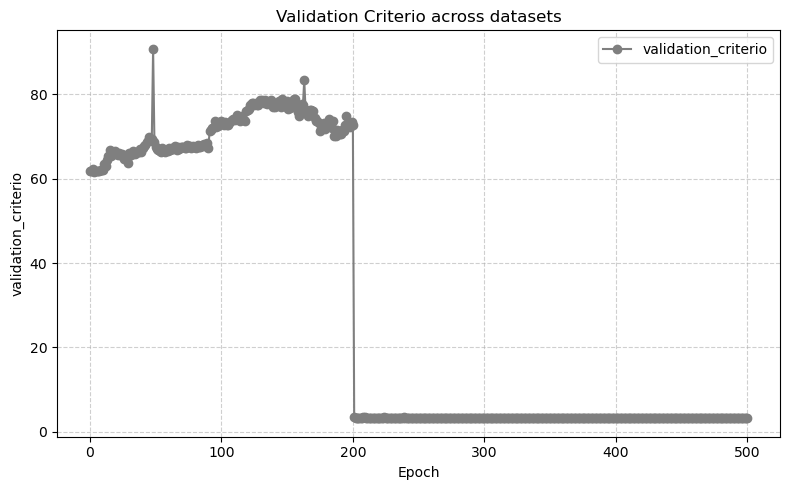


✅ Visualization complete.


In [29]:
visualize_epoch_metrics(
 save_dir_path,
["train_prediction_loss_", "val_prediction_loss_",'val_prediction_loss_training_set',  "train_variance_loss_", "val_variance_loss_", "train_total_loss_", "train_repulsion_loss_", "validation_criterio"],
plot_on_same_graph=True,
verbose=True
)



📊 Processing directory: val_trajectories_data


/tmp/ipykernel_7013/549592778.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  epoch_cmap = cm.get_cmap("viridis")
/tmp/ipykernel_7013/549592778.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  traj_id_cmap = cm.get_cmap("tab10")



For the epoch_500 in val_trajectories_data the values are:
92: X_mean = 9.2515 ± 1.4708, U_mean = -31.5399 ± 3.1729 and A=13.564677634903196, phi=-2.7802771843251053
64: X_mean = 11.8698 ± 1.2616, U_mean = -29.3556 ± 2.3807 and A=11.313750136394223, phi=-2.8600808883112765
6: X_mean = 28.9795 ± 3.9860, U_mean = -23.5832 ± 2.2404 and A=3.4643759649388923, phi=0.5272390069263062
71: X_mean = 14.7598 ± 1.2375, U_mean = -32.3554 ± 2.4659 and A=11.916409964678161, phi=2.852305948671001
50: X_mean = 36.4849 ± 3.3080, U_mean = -27.1024 ± 1.9324 and A=10.000058677513797, phi=0.3462875031667587
103: X_mean = 10.7459 ± 1.6435, U_mean = -34.5770 ± 2.7955 and A=14.352710459026934, phi=3.1257578094931984

📊 Processing directory: val_train_set_trajectories_data

For the epoch_500 in val_train_set_trajectories_data the values are:
2: X_mean = 25.6069 ± 6.4306, U_mean = -22.5374 ± 4.6290 and A=2.0004916751010886, phi=-1.322539930867642
120: X_mean = 46.1660 ± 3.7627, U_mean = -28.2724 ± 3.4354 and A=

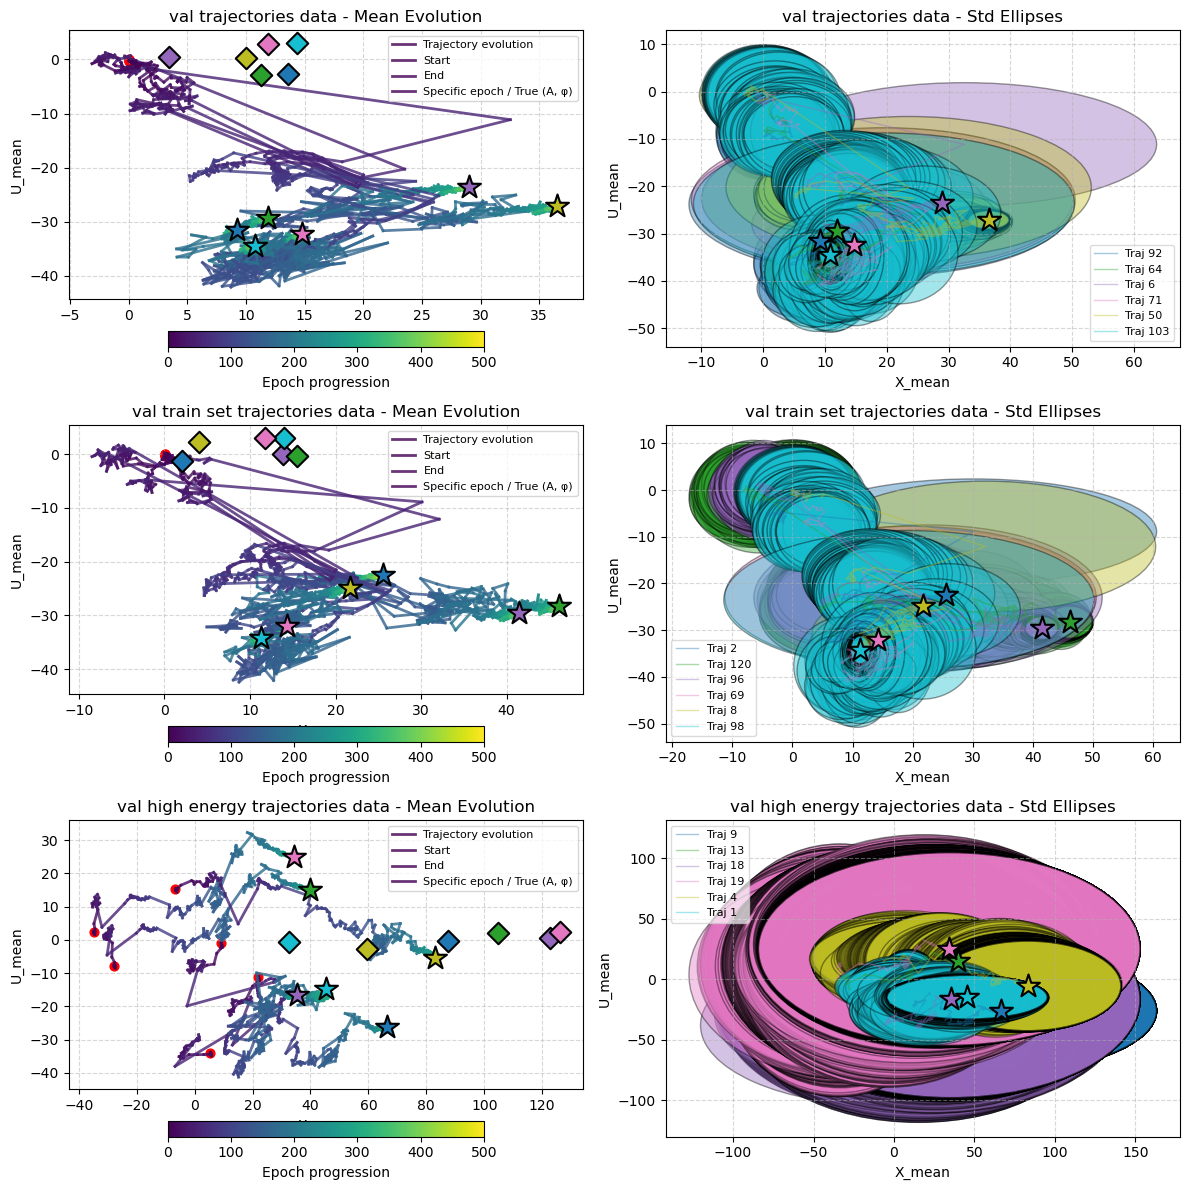


✅ Mean + Std (ellipse) visualization complete.


In [30]:
visualize_trajectory_movements_with_std_ellipses(save_dir_path, number_of_points_to_plot=6, right_plot_alpha=0.4, verbose=True, specific_epoch = 'last', visualize_true_constants=True,train_id_df_added=train_id_df_added,val_id_df_added=val_id_df_added,val_id_df_high_energy_added=val_id_df_high_energy_added)

In [ ]:
val_differencies_df, val_train_differencies_set_df, val_high_energy_differencies_df = analyze_means_with_constants(
    save_dir_path=save_dir_path,
    specific_epoch='last',
    train_id_df_added=train_id_df_added,
    val_id_df_added=val_id_df_added,
    val_id_df_high_energy_added=val_id_df_high_energy_added
)

📂 Using data from epoch: epoch_500
✅ Data extraction complete.


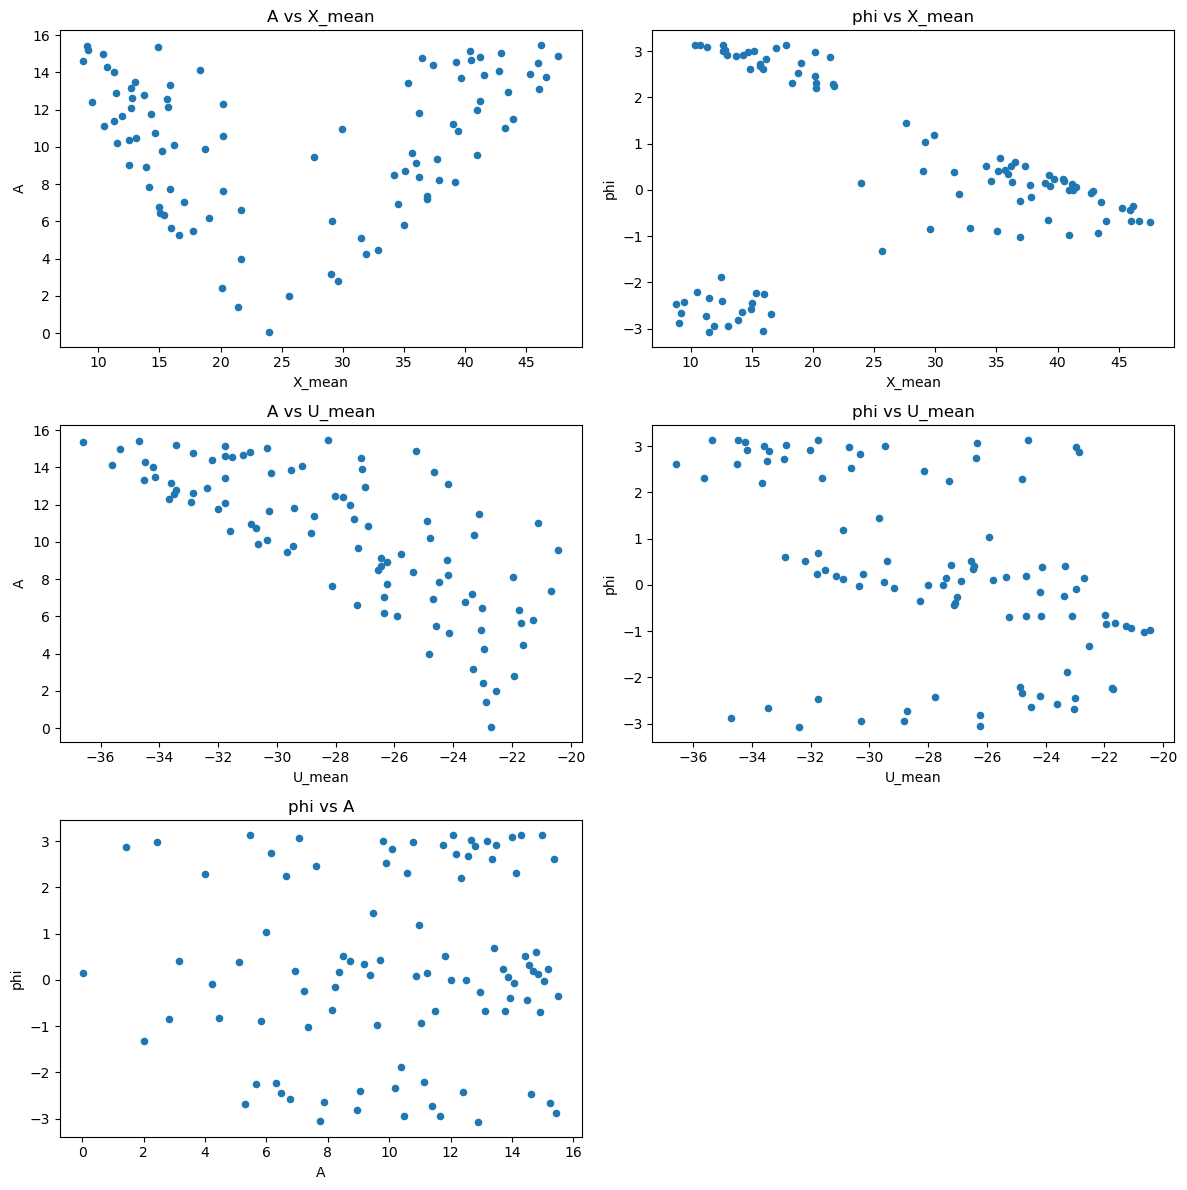

In [47]:
plot_differencies(val_train_differencies_set_df)

📊 Analyzing 501 epochs across 3 directories...

📁 Processing directory: val_trajectories_data


/tmp/ipykernel_7013/952525528.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("plasma")



📁 Processing directory: val_train_set_trajectories_data

📁 Processing directory: val_high_energy_trajectories_data


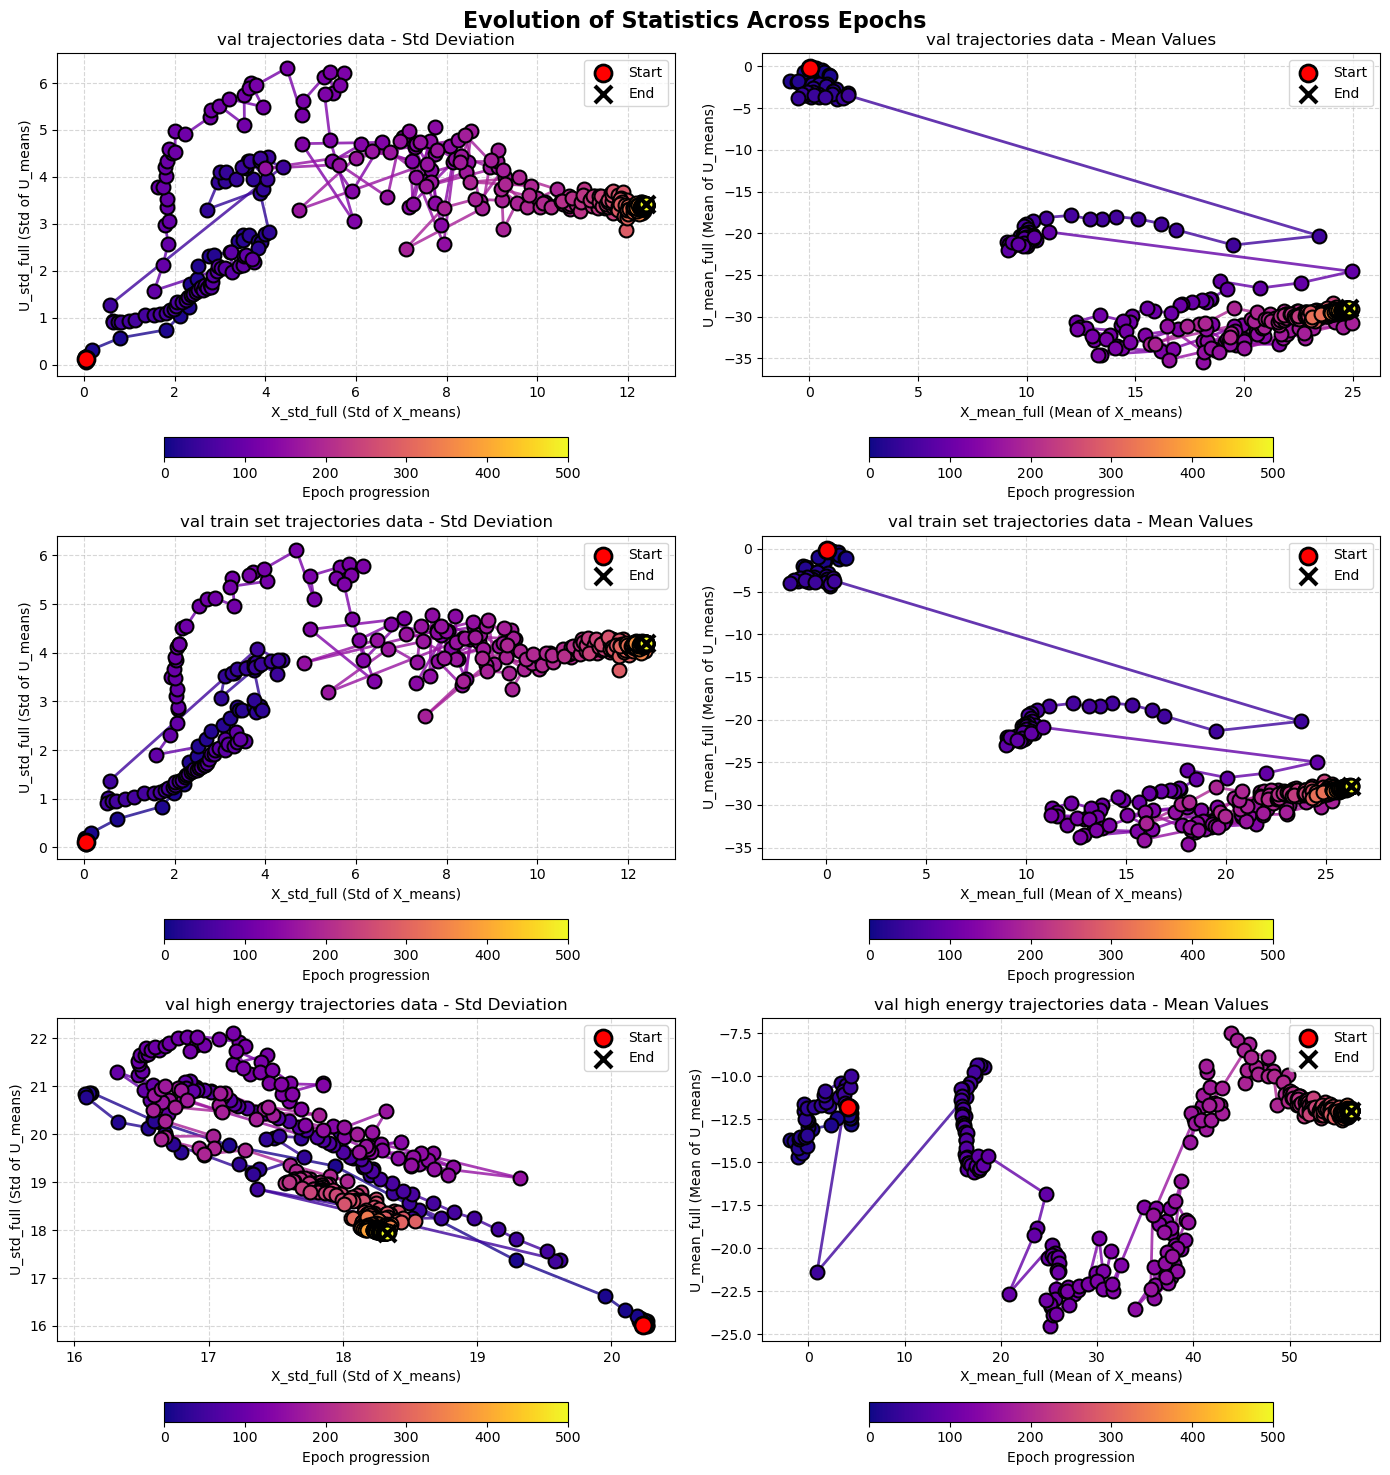

In [25]:
analyze_folders_means(save_dir_path, locate_epoch=None)

In [60]:
device = "cuda"
mapping_net = SimpleStackedHamiltonianNetwork(
    #Hpw many Step_1 + Step_2 layers to stack
    n_layers=10,
    # MLP Architecture parameters
    hidden_dims= [20, 40, 20],
    n_hidden_layers = None,   #Leave None if you provide list on hidden_dims
    
    # Activation parameters
    activation = 'gelu',
    activation_params = None,
    final_activation = None,   #Final layer activation function
    
    # Initialization parameters
    weight_init = 'orthogonal',
    weight_init_params = {'gain': 1},
    bias_init = 'zeros',
    bias_init_value = 0.0,
    
    
    # Architectural choices
    use_bias = True,
    
    # Input/Output parameters
    input_dim = 2,  # x or u and t
    output_dim = 1,  # scalar G or F
    a_eps_min= 0.1,  # Minimum value for a
    a_eps_max= 10,  # Maximum value for a  
    a_k= 0.1
).to(device)

checkpoint_path = os.path.join(save_dir_path, "checkpoint_epoch_400.pt")

load_checkpoint(path=checkpoint_path, mapping_net=mapping_net, device=device, optimizer=None, scheduler=None)

inverse_net = InverseStackedHamiltonianNetwork(forward_network=mapping_net)


Successfully loaded model
Created inverse network with 10 reverse layers


/home/thomasdev/Desktop/Hamilton_Jacobi_NN/Hamilton_Jacobi_NN/modules.py:3045: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=devic

In [175]:
def test_model_in_single_trajectory(get_data_from_trajectory_id_function, prediction_loss_function, test_id_df, test_df, trajectory_id, mapping_net, inverse_net, device, point_indexes_observed, connect_points):
    test_trajectory_data = get_data_from_trajectory_id_function(test_id_df, test_df, trajectory_ids=trajectory_id)
    x = torch.as_tensor(test_trajectory_data['x'].to_numpy(dtype=np.float32), device=device)
    u = torch.as_tensor(test_trajectory_data['u'].to_numpy(dtype=np.float32), device=device)
    t = torch.as_tensor(test_trajectory_data['t'].to_numpy(dtype=np.float32), device=device)

    if point_indexes_observed: #Test prediction ability on full trajectory given points on the trajectory
        X_final, U_final, t_final = mapping_net(x[point_indexes_observed], u[point_indexes_observed], t[point_indexes_observed])
        X_final_mean = X_final.mean()
        U_final_mean = U_final.mean()
        X_final_full_shape = torch.full_like(t, fill_value=X_final_mean.item())
        U_final_full_shape = torch.full_like(t, fill_value=U_final_mean.item())
        x_pred, u_pred, _ = inverse_net(X_final_full_shape, U_final_full_shape, t)
        pred_loss_full_trajectory = prediction_loss_function(x_pred=x_pred, u_pred=u_pred, X_labels=x, U_labels=u)
        plot_prediction_vs_ground_truth(x=x, u=u, x_pred=x_pred, u_pred=u_pred, pred_loss_full_trajectory=pred_loss_full_trajectory, t=t, trajectory_id=trajectory_id, point_indexes_observed=point_indexes_observed, figsize=(12, 7), connect_points=connect_points)





        


In [178]:
test_id_df

,trajectory_id,x0,u0,energy,generated_points,start_index,end_index
53,53,1.949238,10.109480,53.000562,242,12826,13068
81,81,6.964184,-10.653676,81.000331,242,19602,19844
39,39,-4.811351,7.406231,39.000678,242,9438,9680
117,117,-4.987248,14.461239,117.000033,242,28314,28556
75,75,-6.527532,-10.363015,75.000380,242,18150,18392
12,12,3.302146,-3.619065,12.000901,242,2904,3146
88,88,0.494051,13.257317,88.000273,242,21296,21538
7,7,-0.169535,3.738067,7.000942,242,1694,1936
67,67,10.305415,-5.272506,67.000446,242,16214,16456
101,101,-6.898615,12.426160,101.000165,242,24442,24684


Observed time points: [0.]


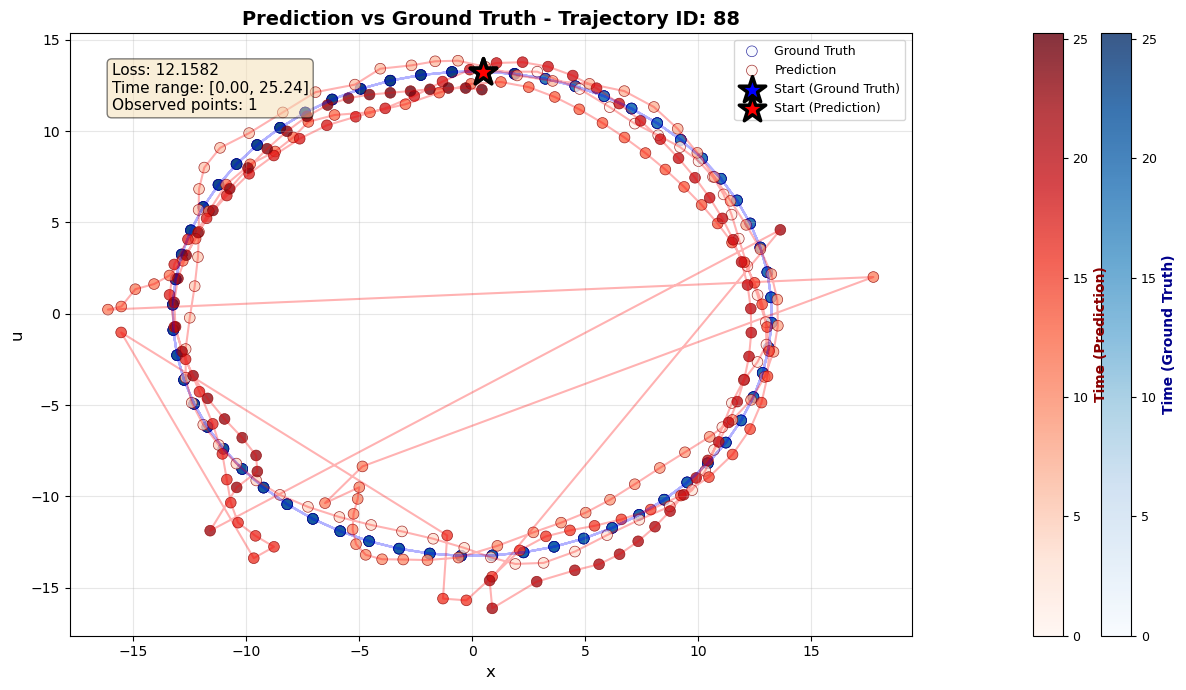

In [197]:
test_model_in_single_trajectory(get_data_from_trajectory_id_function=get_data_from_trajectory_id, prediction_loss_function=prediction_loss, test_id_df=test_id_df, test_df=test_df, trajectory_id=88, mapping_net=mapping_net, inverse_net=inverse_net, device=device, point_indexes_observed=[0], connect_points=True)